### Import libraries and create DataFrame from csv 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prompt user for week selection
start_week = int(input("Enter the start week for analysis: "))
end_week = int(input("Enter the end week for analysis (enter the same as start week for single week analysis): "))
weeks = str(start_week) if start_week == end_week else f"{start_week} - {end_week}"

# Function to read, preprocess, group by player, and aggregate data for the selected weeks
def read_data(start_week, end_week):
    data = pd.DataFrame()

    for week in range(start_week, end_week + 1):
        temp_df = pd.read_excel("TE_Data.xlsx", sheet_name=f"Week{week}")

        # Preprocess: Drop irrelevant columns and convert data types
        temp_df.drop(['FL', 'ROST'], axis=1, inplace=True)
        convert = temp_df.select_dtypes('object').columns.difference(['Player'])
        temp_df[convert] = temp_df[convert].apply(lambda x: pd.to_numeric(x.str.replace(',', ''), errors='coerce')).fillna(0)
        temp_df['Rank'] = temp_df['Rank'].astype('Int64')

        # Group by 'Player' and aggregate data
        if data.empty:
            data = temp_df
        else:
            data = data.merge(temp_df, on='Player', suffixes=('', '_week' + str(week)))

    # Apply custom aggregation logic
    for column in data.columns:
        if column.endswith(tuple([f'_week{week}' for week in range(start_week + 1, end_week + 1)])):
            base_column = column.split('_week')[0]
            if base_column in ['Rank', 'Player']:  # Take the latest value
                data[base_column] = data[column]
            elif base_column in ['LG']:  # Take the maximum value
                data[base_column] = data[[base_column, column]].max(axis=1)
            else:  # Sum the values
                data[base_column] += data[column]
            data.drop(column, axis=1, inplace=True)  # Drop the extra week column

    # Calculate 'Y/A' and 'Y/R' based on summed values
    data['Y/R'] = (data['YDS'] / data['REC']).round(1)
    data['FPTS/G'] = (data['FPTS'] / data['G']).round(1)

    return data

# Load and aggregate data for the selected weeks
df = read_data(start_week, end_week)

# Recalculate 'Rank' based on 'FPTS' in descending order
df['Rank'] = df['FPTS'].rank(ascending=False, method='min').astype('int')

# Create 'Weeks' column
if start_week == end_week:
    df['Weeks'] = str(start_week)
else:
    df['Weeks'] = f"{start_week} - {end_week}"

df = df.sort_values(by='Rank')
# df.head(10)

### Convert relevant stats to a per-game basis and create the final stats for analysis

In [2]:
# Define columns for per-game calculation
per_game = list(df.columns[2:])

# Define columns to exclude from the per-game calculation
exclude_per_game = ['Y/R', 'LG', 'G', 'FPTS', 'FPTS/G', 'Weeks']

# Create columns and convert stats to a per-game basis for the defined columns, not those in the exclude list
for col in per_game:
    if col not in exclude_per_game:
        df[col + '/game'] = (df[col] / df['G']).round(1)

# Define final columns to be used for analysis, combines excluded and new per-game columns
final_columns = exclude_per_game + [col + '/game' for col in per_game if col not in exclude_per_game]

# Display final columns with 'Rank' and 'Player'
# df[['Rank', 'Player'] + final_columns].head(10)

### Calculate the correlations for the final stats across different conditions

In [3]:
# Define columns and columns to exclude for correlation calculation, from final columns
exclude_corr = ['FPTS/G', 'FPTS', 'G', 'Weeks']
corr_columns = [col for col in final_columns if col not in exclude_corr]

# Define a function to calculate correlations
def compute_correlations(dataframe, corr_columns):
    return dataframe[corr_columns].corrwith(dataframe['FPTS/G'])

# Compute correlations for various conditions
corr_all = compute_correlations(df, corr_columns)
corr_nonzero = compute_correlations(df[df['FPTS/G'] > 0], corr_columns)
corr_top50 = compute_correlations(df[df['Rank'] <= 50], corr_columns)
corr_top25 = compute_correlations(df[df['Rank'] <= 25], corr_columns)

# Compile all correlations into a DataFrame for comparison
df_corr = pd.DataFrame({
    'All Players': corr_all,
    'FPTS > 0': corr_nonzero,
    'Top 50 Players': corr_top50,
    'Top 25 Players': corr_top25
})

# Calculate the average correlation across the four conditions, adding 'Average' column to DataFrame
df_corr['Correlation'] = df_corr.mean(axis=1)

# Display the correlation DataFrame
# df_corr.round(2)

/home/codespace/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/codespace/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/codespace/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/codespace/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/codespace/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/codespace/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/codespace/.local/lib/python3.10/si

### Assign the weights for the final stats

In [4]:
# Calculate R^2 for the 'Average' correlation, adding 'R^2' column to DataFrame
df_corr['R^2'] = df_corr['Correlation'] ** 2

# Define the specific stats for which you want to assign weights
specific_stats = ['REC/game',
                'TGT/game',
                'YDS/game',
                '20+/game',
                'TD/game']

# Define the calculation to assign weights
def weight_calc(row, specific_stats):
    if row.name in specific_stats:
        return 1 + row['R^2']  # Assign weight based on R^2 for specific stats
    else:
        return 1  # Default weight for other stats
    
# Assign weights based on the given criteria, adding 'Weight' column to DataFrame
df_corr['Weight'] = df_corr.apply(weight_calc, specific_stats=specific_stats, axis=1)

# Display the new columns in the DataFrame
# df_corr[['Correlation', 'R^2', 'Weight']].round(2)

### Multiply the assigned weights to the final stats

In [5]:
# Multiply each relevant column by its corresponding weight
for col in corr_columns:
    weight = df_corr.loc[col, 'Weight']
    df[col + '_weighted'] = (df[col] * weight).round(1)

# Extract the weighted columns
weight_columns = [col + '_weighted' for col in corr_columns]

# Display the new weighted stats columns
df_weight = df[['Rank', 'Player', 'FPTS/G'] + weight_columns]
# df_weight.sort_values(by=['FPTS/G'],ascending=False).head(10)

### Calculate each player's average weighted score and rank them from high to low

In [6]:
# Define select columns to be used for the average weighted score
avg = ['REC/game_weighted',
 'TGT/game_weighted',
 'YDS/game_weighted',
 '20+/game_weighted',
 'TD/game_weighted',
 'FPTS/G']

# Calculate the average weighted score for the select columns
df['Score'] = df[avg].mean(axis=1).round(1)

# Rank both of the average weighted scores with NaN handling
df['Final Rank'] = df.sort_values('Score', ascending=False)\
                ['Score'].rank(method='first', ascending=False, na_option='bottom').astype(int)

# Calculate the variance in ranking both ranks
df['Variance'] = df['Rank'] - df['Final Rank']

### Display results of the average weighted score and rank

In [7]:
# List of columns to be excluded
final_columns_exclude = ['Y/R', 'LG', 'ATT/game', 'YDS.1/game', 'TD.1/game']

# Exclude the specified columns from final_columns
final_columns = [col for col in final_columns if col not in final_columns_exclude]

# Create final analysis columns
analysis = df[['Rank', 'Final Rank', 'Player', 'Score', 'Variance'] + final_columns]
analysis.set_index('Rank', inplace=True)
analysis = analysis.sort_values(by='Final Rank', ascending=True)

# Export to Excel
analysis.to_excel("TE_Analysis.xlsx", index=False)

# Display the top 30 rows
analysis.head(30)


,Final Rank,Player,Score,Variance,G,FPTS,FPTS/G,Weeks,REC/game,TGT/game,YDS/game,20+/game,TD/game
Rank,,,,,,,,,,,,,
1,1,T.J. Hockenson (MIN),31.9,0,4,69.8,17.4,9 - 12,6.8,10.0,77.0,1.2,0.5
7,2,George Kittle (SF),29.6,5,3,48.4,16.1,9 - 12,4.7,6.0,74.7,2.7,0.7
6,3,Trey McBride (ARI),25.8,3,4,48.6,12.2,9 - 12,5.8,7.5,64.0,0.8,0.0
21,4,Pat Freiermuth (PIT),24.9,17,2,22.7,11.4,9 - 12,5.0,6.0,63.5,1.0,0.0
3,5,Dalton Schultz (HOU),23.4,-2,4,50.5,12.6,9 - 12,4.2,5.5,58.8,1.2,0.5
2,6,Dalton Kincaid (BUF),23.0,-4,4,51.6,12.9,9 - 12,6.5,7.5,54.0,0.2,0.2
5,7,David Njoku (CLE),22.0,-2,4,48.9,12.2,9 - 12,5.8,9.8,49.8,0.2,0.2
11,8,Travis Kelce (KC),21.0,3,3,34.9,11.6,9 - 12,5.3,6.7,49.7,0.7,0.3
17,9,Mark Andrews (BAL),19.6,8,3,27.7,9.2,9 - 12,4.3,5.3,49.0,0.7,0.0


### Compare per-game stats of two players and visualize the results

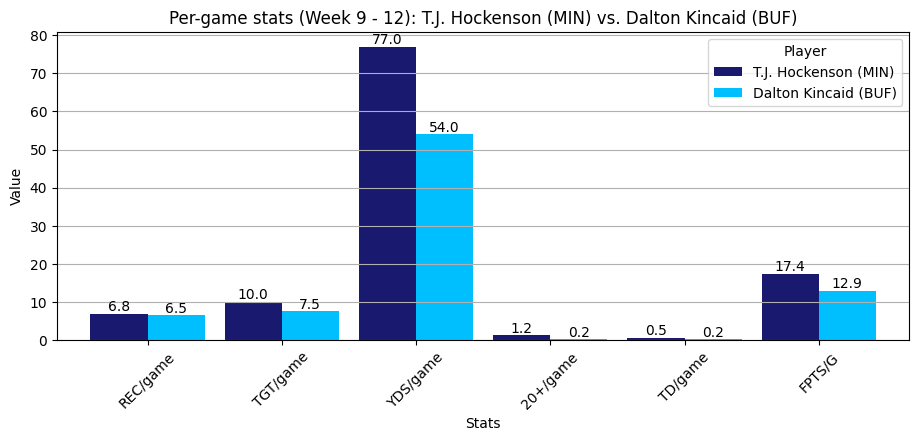

,Final Rank,G,FPTS,FPTS/G,Weeks,REC/game,TGT/game,YDS/game,20+/game,TD/game
Player,,,,,,,,,,
T.J. Hockenson (MIN),1,4,69.8,17.4,9 - 12,6.8,10.0,77.0,1.2,0.5
Dalton Kincaid (BUF),6,4,51.6,12.9,9 - 12,6.5,7.5,54.0,0.2,0.2


In [8]:
# Prompt the user to input the name of the players
player1 = input("Enter player 1 name")
player2 = input("Enter player 2 name")

# Extract and reorder rows for the two specified players
# Filter rows where the 'Player' column contains the names entered by the user
players = df[df['Player'].str.contains(player1) | df['Player'].str.contains(player2)]
players.set_index('Player', inplace=True)
player1_match = players.index[0] if player1 in players.index[0] else players.index[1]
player2_match = players.index[1] if player2 in players.index[1] else players.index[0]
players = players.reindex([player1_match, player2_match])

# Define columns to be compared
compare_columns = [col.replace('_weighted', '') for col in avg]

# Define a function to compare per-game stats of two players
def compare(player1, player2):

    # Plot the data
    chart = players[compare_columns].T.plot(kind='bar',
                                            color=['midnightblue', 'deepskyblue'],
                                            width=0.85,
                                            figsize=(11,4))

    # Format chart
    plt.title(f'Per-game stats (Week {weeks}): {player1} vs. {player2}')
    plt.xlabel('Stats')
    plt.ylabel('Value')
    plt.grid(axis='y')
    plt.xticks(rotation=45)

    # Add data labels above the bars
    for p in chart.patches:
        chart.annotate(f'{p.get_height():.1f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 5), 
                    textcoords = 'offset points')

    plt.show()

# Call the 'compare' function which creates and displays the visualization
compare(player1_match, player2_match)
players[['Final Rank'] + final_columns]